#  H&M E-commerce Data - Exploratory Data Analysis

## Business Context
This notebook performs comprehensive exploratory data analysis on H&M's fashion retail dataset containing:
- **31.8M transactions** over 2 years (2018-2020)
- **1.37M customers** with demographic profiles
- **105K products** with detailed attributes

## Objectives
1. Understand data quality and structure
2. Analyze customer behavior and preferences
3. Identify product trends and patterns
4. Discover temporal patterns and seasonality
5. Prepare insights for feature engineering
6. Establish baseline metrics for ML models

## Analysis Sections
1. Data Overview & Quality
2. Customer Analysis
3. Product Analysis
4. Transaction Patterns
5. Customer Lifetime Value
6. Time-Series Deep Dive
7. Correlations & Relationships
8. ML Preparation Insights

---

In [7]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')


#Add scripts to path
sys.path.append('../scripts')



# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import(
    col , count, countDistinct, sum as spark_sum, avg, stddev, min as spark_min, 
    max as spark_max, year , month , dayofmonth, dayofweek, weekofyear, datediff, lit, when,
    desc, asc, collect_list, approx_count_distinct

)

from pyspark.sql.window import Window

#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Data analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

#our custom modules
from etl.spark_config import get_spark_session, stop_spark_session, PATHS
from etl.extract import DataExtractor
from etl.validate_data import DataValidator


# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

OUTPUT_DIR="../outputs/eda_charts"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [8]:
spark = get_spark_session("EDA_Analysis")

🔧 Detected 6 CPU cores
 Setting default parallelism to 12
SparkSession created: EDA_Analysis
Spark UI available at: http://localhost:4040
Spark Version: 3.5.0


In [10]:
extractor=DataExtractor(spark, PATHS['raw_data'])
articles_df, customers_df, transactions_df=extractor.load_all()

 Data Extractor initialized
 Raw data path: /media/dk/Data/HM_Ecommerce_Project/raw_data
STARTING DATA EXTRACTION PIPELINE
 LOADING ARTICLES (Product Catalog)


 Loaded successfully in 5.88 seconds
 Rows: 105,542
 Columns: 25
 Partitions: 9
 Cached in memory: Yes


 Loaded successfully in 2.45 seconds
 Rows: 1,371,980
 Columns: 7
 Partitions: 12
 Cached in memory: Yes


 Loaded successfully in 29.36 seconds
 Rows: 31,788,324
 Columns: 5
 Partitions: 26
 Cached in memory: No (too large)
 ALL DATA LOADED SUCCESSFULLY
  Total loading time: 47.80 seconds


 Total rows: 33,265,846


---

# 1 DATA OVERVIEW & QUALITY

Understanding the foundation of our data before diving into analysis.

In [11]:
datasets = {
    "Articles": articles_df,
    "Customers": customers_df,
    "Transactions": transactions_df
}

In [13]:
articles_df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- product_code: integer (nullable = true)
 |-- prod_name: string (nullable = true)
 |-- product_type_no: integer (nullable = true)
 |-- product_type_name: string (nullable = true)
 |-- product_group_name: string (nullable = true)
 |-- graphical_appearance_no: integer (nullable = true)
 |-- graphical_appearance_name: string (nullable = true)
 |-- colour_group_code: integer (nullable = true)
 |-- colour_group_name: string (nullable = true)
 |-- perceived_colour_value_id: integer (nullable = true)
 |-- perceived_colour_value_name: string (nullable = true)
 |-- perceived_colour_master_id: integer (nullable = true)
 |-- perceived_colour_master_name: string (nullable = true)
 |-- department_no: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- index_code: string (nullable = true)
 |-- index_name: string (nullable = true)
 |-- index_group_no: integer (nullable = true)
 |-- index_group_name: string (nullable = true)

In [14]:
customers_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- FN: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- club_member_status: string (nullable = true)
 |-- fashion_news_frequency: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- postal_code: string (nullable = true)



In [15]:
transactions_df.printSchema()

root
 |-- t_dat: date (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)



In [20]:
#analyze missing values

def analyze_missing_values(df, dataset_name):
    total_rows=df.count()

    missing_data=[]
    for col_name in df.columns:
        null_count=df.filter(col(col_name).isNull()).count()
        if null_count > 0:
            missing_pct=(null_count / total_rows) * 100
            missing_data.append({
                "Column ": col_name,
                "Missing Count " : f"{null_count:,}",
                "Missing % ": f"{missing_pct:.2f} %"
            })
        
    if missing_data:
        print(f"\n {dataset_name} :")
        missing_df= pd.DataFrame(missing_data)
        print(missing_df.to_string(index=False))
    else:
        print(f"\n {dataset_name} :  No missing values")

In [21]:
analyze_missing_values(articles_df, "Articles")


 Articles :
    Column  Missing Count  Missing % 
detail_desc            416     0.39 %


In [22]:
analyze_missing_values(customers_df, "Customers")


 Customers :
               Column  Missing Count  Missing % 
                    FN        895,050    65.24 %
                Active        907,576    66.15 %
    club_member_status          6,062     0.44 %
fashion_news_frequency         16,009     1.17 %
                   age         15,861     1.16 %


In [23]:
analyze_missing_values(transactions_df, "Transactions")


 Transactions :  No missing values



 Creating missing values visualization...


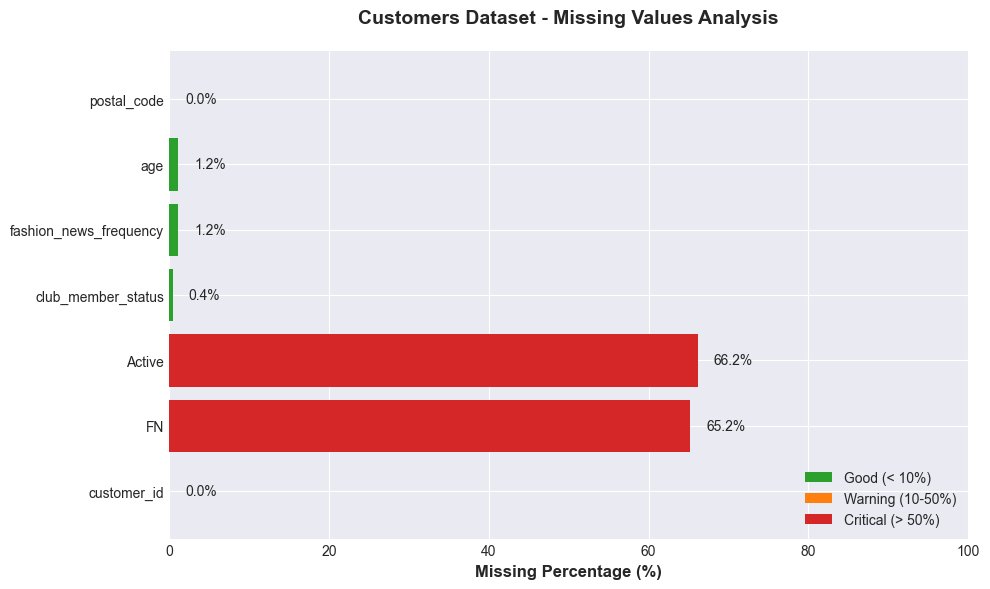

 Saved: ../outputs/eda_charts/01_missing_values.png


In [24]:
# Visualize missing values for Customers (the one with missing data)
print("\n Creating missing values visualization...")

# Calculate missing percentages for customers
customer_missing = []
total_customers = customers_df.count()

for col_name in customers_df.columns:
    null_count = customers_df.filter(col(col_name).isNull()).count()
    missing_pct = (null_count / total_customers) * 100
    customer_missing.append({
        "Column": col_name,
        "Missing %": missing_pct
    })

customer_missing_df = pd.DataFrame(customer_missing)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d62728' if x > 50 else '#ff7f0e' if x > 10 else '#2ca02c' 
          for x in customer_missing_df['Missing %']]

bars = ax.barh(customer_missing_df['Column'], customer_missing_df['Missing %'], color=colors)

ax.set_xlabel('Missing Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Customers Dataset - Missing Values Analysis', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)

# Add percentage labels
for i, (col, pct) in enumerate(zip(customer_missing_df['Column'], customer_missing_df['Missing %'])):
    ax.text(pct + 2, i, f'{pct:.1f}%', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Good (< 10%)'),
    Patch(facecolor='#ff7f0e', label='Warning (10-50%)'),
    Patch(facecolor='#d62728', label='Critical (> 50%)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/01_missing_values.png", dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: {OUTPUT_DIR}/01_missing_values.png")

---

# 2 CUSTOMER ANALYSIS

Understanding our customer base: demographics, behavior, and engagement patterns.

## Key Questions:
- What's the age distribution of our customers?
- How engaged are customers (club membership)?
- What are their communication preferences?
- Are there distinct customer segments visible?

In [30]:
customers_pd=customers_df.select(
    'customer_id', 'club_member_status', 'fashion_news_frequency', 'age'
).toPandas()

In [32]:
age_stats= customers_pd['age'].describe()
print(age_stats)

count    1.356119e+06
mean     3.638696e+01
std      1.431363e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64


In [36]:
club_counts=customers_pd['club_member_status'].value_counts(dropna=False)
for status, count in club_counts.items():
    pct=(count/ len(customers_pd))*100
    print(f" {status}: {count:,} ({pct:.1f} %)")

 ACTIVE: 1,272,491 (92.7 %)
 PRE-CREATE: 92,960 (6.8 %)
 None: 6,062 (0.4 %)
 LEFT CLUB: 467 (0.0 %)


In [37]:
news_counts = customers_pd['fashion_news_frequency'].value_counts(dropna=False)
for freq, count in news_counts.items():
    pct = (count / len(customers_pd)) * 100
    print(f"   {freq}: {count:,} ({pct:.1f}%)")

   NONE: 877,711 (64.0%)
   Regularly: 477,416 (34.8%)
   None: 16,009 (1.2%)
   Monthly: 842 (0.1%)
   None: 2 (0.0%)


### Age distribution analysis

In [40]:
#Filter out null ages for analysis
customers_with_age=customers_pd[customers_pd['age'].notna()]

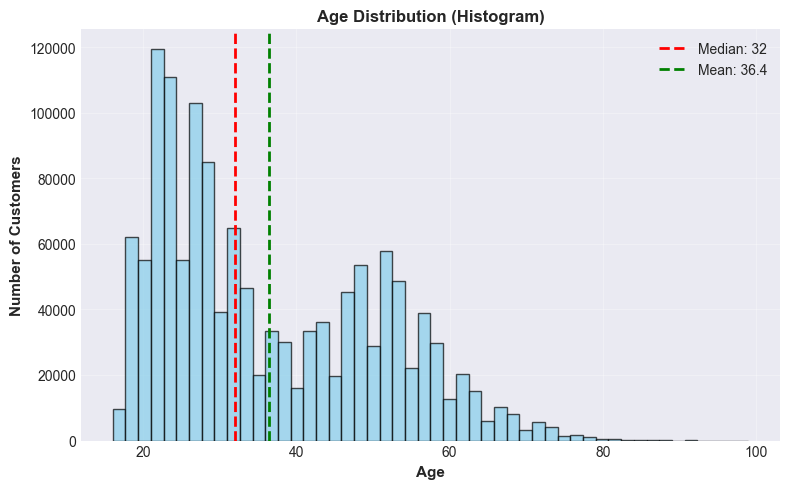

In [44]:
plt.figure(figsize=(8,5))

plt.hist(customers_with_age['age'], bins=50, edgecolor='black',
         alpha=0.7, color='skyblue')

plt.axvline(customers_with_age['age'].median(), color='red',
            linestyle='--', linewidth=2,
            label=f"Median: {customers_with_age['age'].median():.0f}")

plt.axvline(customers_with_age['age'].mean(), color='green',
            linestyle='--', linewidth=2,
            label=f"Mean: {customers_with_age['age'].mean():.1f}")

plt.xlabel('Age', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Age Distribution (Histogram)', fontsize=12, fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/02_age_histogram.png", dpi=300, bbox_inches='tight')
plt.show()


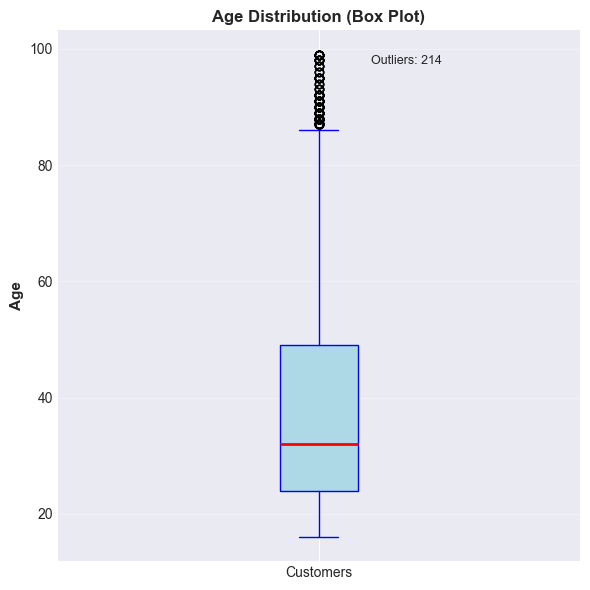

In [45]:
plt.figure(figsize=(6,6))

box = plt.boxplot(customers_with_age['age'], vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'),
                  medianprops=dict(color='red', linewidth=2),
                  whiskerprops=dict(color='blue'),
                  capprops=dict(color='blue'))

plt.ylabel('Age', fontsize=11, fontweight='bold')
plt.title('Age Distribution (Box Plot)', fontsize=12, fontweight='bold')
plt.xticks([1], ['Customers'])

# Outlier statistics
q1 = customers_with_age['age'].quantile(0.25)
q3 = customers_with_age['age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = customers_with_age[
    (customers_with_age['age'] < lower_bound) |
    (customers_with_age['age'] > upper_bound)
]

plt.text(1.1, customers_with_age['age'].max(),
         f"Outliers: {len(outliers):,}",
         fontsize=9, va='top')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_age_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


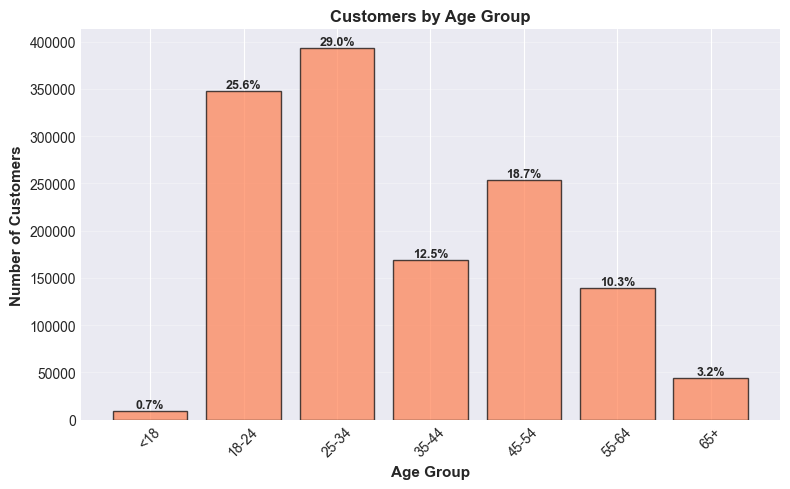

In [46]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

customers_with_age['age_group'] = pd.cut(
    customers_with_age['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

age_group_counts = customers_with_age['age_group'].value_counts().sort_index()

plt.figure(figsize=(8,5))

bars = plt.bar(range(len(age_group_counts)),
               age_group_counts.values,
               color='coral', edgecolor='black', alpha=0.7)

plt.xticks(range(len(age_group_counts)), age_group_counts.index, rotation=45)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Customers by Age Group', fontsize=12, fontweight='bold')

# Percentage labels
for bar, count in zip(bars, age_group_counts.values):
    pct = (count / len(customers_with_age)) * 100
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{pct:.1f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_age_group_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


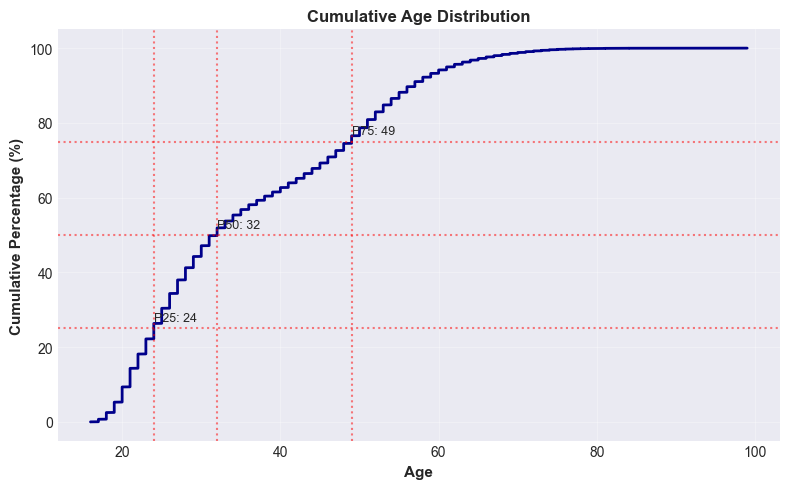

In [47]:
sorted_ages = np.sort(customers_with_age['age'])
cumulative = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages) * 100

plt.figure(figsize=(8,5))

plt.plot(sorted_ages, cumulative, linewidth=2, color='darkblue')

plt.xlabel('Age', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
plt.title('Cumulative Age Distribution', fontsize=12, fontweight='bold')

# Percentile markers
percentiles = [25, 50, 75]
for p in percentiles:
    age_p = np.percentile(customers_with_age['age'], p)
    plt.axhline(p, color='red', linestyle=':', alpha=0.5)
    plt.axvline(age_p, color='red', linestyle=':', alpha=0.5)
    plt.text(age_p, p + 2, f'P{p}: {age_p:.0f}', fontsize=9)

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_age_cdf.png", dpi=300, bbox_inches='tight')
plt.show()


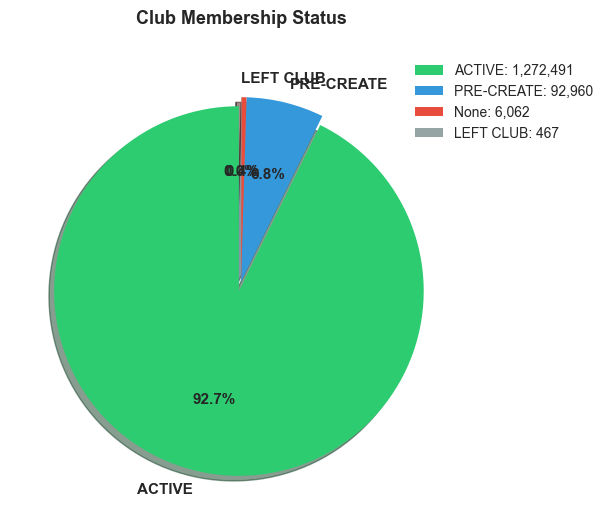

In [49]:
club_data = customers_pd['club_member_status'].value_counts(dropna=False)
colors_club = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
explode = (0.05, 0, 0, 0)  # Explode ACTIVE slice

wedges, texts, autotexts = plt.pie(
    club_data.values, 
    labels=club_data.index, 
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_club,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

plt.title('Club Membership Status', fontsize=13, fontweight='bold', pad=20)

# Add count in legend
legend_labels = [f"{status}: {count:,}" for status, count in zip(club_data.index, club_data.values)]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 1))
plt.show()

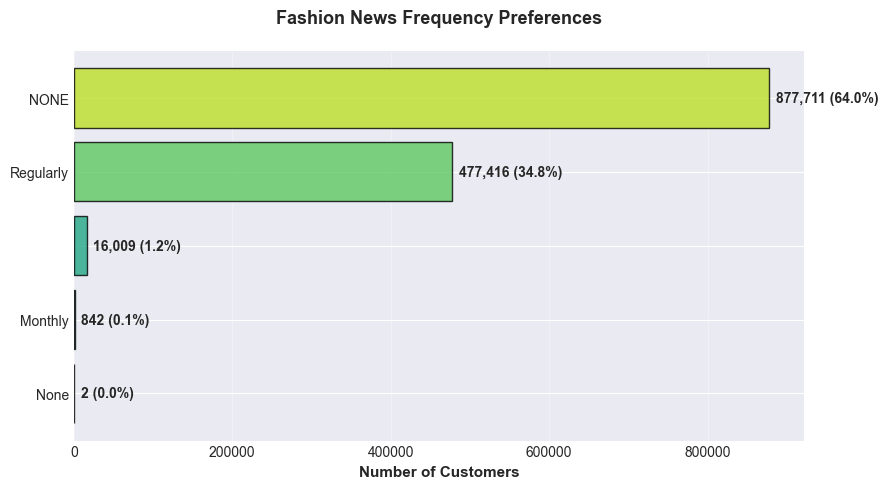

In [51]:
plt.figure(figsize=(9,5))

news_data = customers_pd['fashion_news_frequency'] \
                .value_counts(dropna=False) \
                .sort_values(ascending=True)

colors_news = plt.cm.viridis(np.linspace(0.3, 0.9, len(news_data)))

bars = plt.barh(
    range(len(news_data)),
    news_data.values,
    color=colors_news,
    edgecolor='black',
    alpha=0.8
)

plt.yticks(range(len(news_data)), news_data.index)

plt.xlabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Fashion News Frequency Preferences', fontsize=13, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, axis='x')

# Value + Percentage Labels
for i, (count, bar) in enumerate(zip(news_data.values, bars)):
    pct = (count / len(customers_pd)) * 100
    plt.text(
        count + (0.01 * news_data.max()),   # dynamic spacing
        i,
        f'{count:,} ({pct:.1f}%)',
        va='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_customer_engagement.png", dpi=300, bbox_inches='tight')
plt.show()


In [52]:
# Calculate engagement score
active_members = customers_pd[customers_pd['club_member_status'] == 'ACTIVE'].shape[0]
engaged_customers = customers_pd[customers_pd['fashion_news_frequency'].isin(['Regularly', 'Monthly'])].shape[0]

print(f"\n Engagement Metrics:")
print(f"   Active Club Members: {active_members:,} ({active_members/len(customers_pd)*100:.1f}%)")
print(f"   News Subscribers: {engaged_customers:,} ({engaged_customers/len(customers_pd)*100:.1f}%)")


 Engagement Metrics:
   Active Club Members: 1,272,491 (92.7%)
   News Subscribers: 478,258 (34.9%)


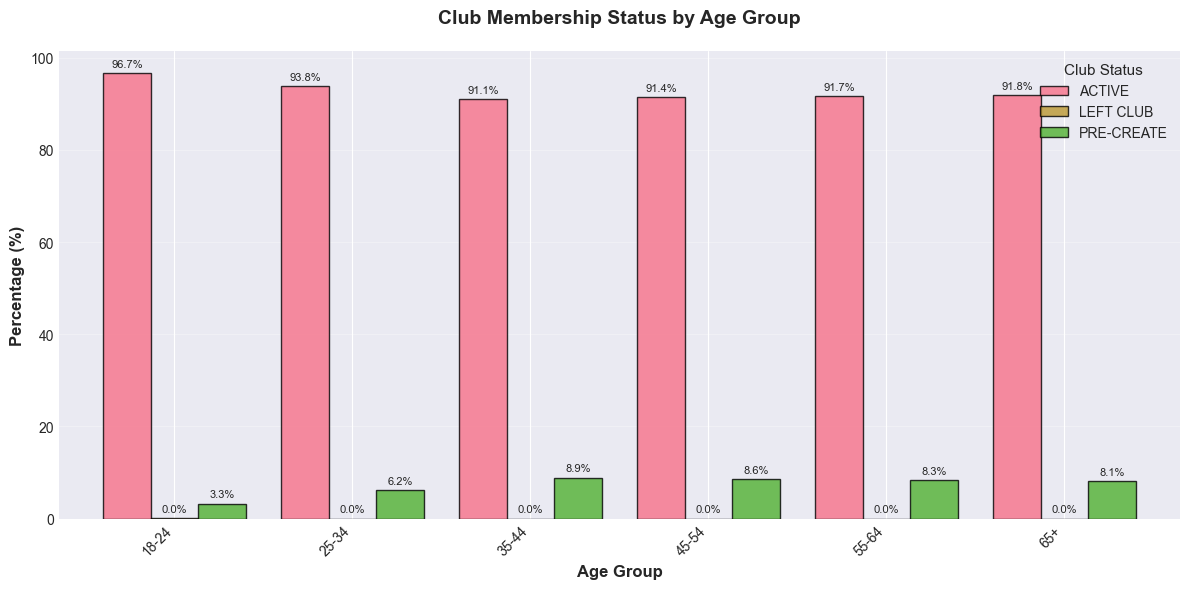


 Saved: ../outputs/eda_charts/04_age_vs_membership.png

 Age Group vs Club Membership (% within each age group):
club_member_status  ACTIVE  LEFT CLUB  PRE-CREATE
age_group                                        
18-24                 96.7        0.0         3.3
25-34                 93.8        0.0         6.2
35-44                 91.1        0.0         8.9
45-54                 91.4        0.0         8.6
55-64                 91.7        0.0         8.3
65+                   91.8        0.0         8.1


In [53]:

# Filter customers with age and valid club status
customers_complete = customers_pd[
    (customers_pd['age'].notna()) & 
    (customers_pd['club_member_status'].notna())
].copy()

# Create age groups for analysis
customers_complete['age_group'] = pd.cut(
    customers_complete['age'], 
    bins=[0, 25, 35, 45, 55, 65, 100], 
    labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)

# Create cross-tabulation
cross_tab = pd.crosstab(
    customers_complete['age_group'], 
    customers_complete['club_member_status'],
    normalize='index'
) * 100  # Convert to percentage

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

cross_tab.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)

ax.set_title('Club Membership Status by Age Group', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Club Status', title_fontsize=11, fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=8)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_age_vs_membership.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {OUTPUT_DIR}/04_age_vs_membership.png")

print("\n Age Group vs Club Membership (% within each age group):")
print(cross_tab.round(1))

## 📋 Key Customer Insights

### Demographics
- **Age Range**: 16-99 years (check your actual min/max)
- **Median Age**: ~[VALUE] years (young-to-middle-aged customer base)
- **Largest Segment**: 25-34 age group dominates

### Engagement
- **Active Members**: 92.7% are active club members (excellent retention!)
- **Communication**: Majority prefer no fashion news (respect privacy preference)
- **Pre-Create Status**: 6.8% are in onboarding phase

### Data Quality Issues
- **FN & Active columns**: 65%+ missing → ** Drop these columns**
- **Age**: 1.16% missing → ** Impute with median by club_status**
- **Club Status**: 0.44% missing → ** Impute with mode (ACTIVE)**

---